👋 This code is heavily inspired from [Sebastian Raschka](https://x.com/rasbt)'s excellent book, "[Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)".

I highly recommend buying and reading that book.

My code here is taken directly from Sebastian's book, but with some slight modifications to make it financial domain-specific.

Questions?  Feel free to DM me on [Twitter](https://x.com/virattt).

### 0. Setup and installation

In [1]:
!pip install datasets tiktoken --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install tensorflow>=2.15.0  tqdm>=4.66 --quiet

In [3]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x78f1103ee290>)

### 1. Download instruction dataset

In [5]:
from datasets import Dataset, DatasetDict, load_dataset, concatenate_datasets

# Pull the existing dataset from huggingface
dataset_path_hf = "virattt/financial-qa-10K"
existing_dataset_hf = load_dataset(dataset_path_hf)

In [6]:
# Assuming existing_dataset_hf is your DatasetDict
train_dataset = existing_dataset_hf['train']

# Convert to a list of dictionaries
dataset_list = train_dataset.to_list()

# Extract question, answer, and context
data = [{'instruction': "Answer the following question.", 'input': item['question'], 'output': item['answer']} for item in dataset_list]

In [7]:
print("Example entry:\n", data[500])

Example entry:
 {'instruction': 'Answer the following question.', 'input': 'When did Costco Wholesale Corporation begin its operations?', 'output': 'Costco Wholesale Corporation began its operations in 1983.'}


In [8]:
print("Another example entry:\n", data[1000])

Another example entry:
 {'instruction': 'Answer the following question.', 'input': 'What year was American Express founded and when was it incorporated as a New York corporation?', 'output': 'American Express was founded in 1850 and was incorporated as a New York corporation in 1965.'}


### 2. Implement prompt formatter

In [9]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [10]:
model_input = format_input(data[500])
desired_response = f"\n\n### Response:\n{data[500]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer the following question.

### Input:
When did Costco Wholesale Corporation begin its operations?

### Response:
Costco Wholesale Corporation began its operations in 1983.


### 3. Partition the dataset

In [11]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)   # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 5950
Validation set length: 350
Test set length: 700


### 3. Implement InstructionDataset class

In [12]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.encoded_texts = []

    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(
          tokenizer.encode(full_text)
      )

  def __getitem__(self, index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.data)

In [13]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


### 4. Implement custom dataset collate function

In [14]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
# Test out the function
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [17]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

### 5. Initialize data loaders

In [18]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

### 6. Implement GPTModel

In [19]:
import torch
from torch import nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    normalized_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * normalized_x + self.shift

In [20]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [21]:
# Implement feed-forward neural network
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
        GELU(),
        nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

In [22]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out                  # 768
    self.num_heads = num_heads          # 12
    self.head_dim = d_out // num_heads  # 64
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(
            context_length,             # 1024
            context_length,             # 1024
          ), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, embedding_length = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # Add the num_heads and head_dim dimensions
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)       # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim) # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)   # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64

    # Transpose from (batch_size, num_tokens, num_heads, head_dim) to (batch_size, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)

    # Calculate attention scores
    attention_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    # Mask the attention scores
    attention_scores.masked_fill_(mask_bool, -torch.inf)

    # Calculate attention weights
    attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)

    # Apply dropout to attention weights
    attention_weights = self.dropout(attention_weights)

    # Calculate context vectors
    context_vectors = (attention_weights @ values).transpose(1, 2)

    # Concatenate the context vectors
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.d_out)
    return self.out_proj(context_vectors)

In [23]:
class TransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.att = MultiHeadAttention(
        d_in=config["emb_dim"],
        d_out=config["emb_dim"],
        context_length=config["context_length"],
        dropout=config["drop_rate"],
        num_heads=config["n_heads"],
        qkv_bias=config["qkv_bias"]
    )

    self.ff = FeedForward(config)
    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.drop_shortcut = nn.Dropout(config["drop_rate"])

  def forward(self, x):
    shortcut = x

    # Attention layer
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back

    # Feedforward layer
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back
    return x

In [24]:
class GPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
    self.drop_embedding = nn.Dropout(config["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])]
    )

    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, sequence_length = in_idx.shape
    tok_emb = self.tok_emb(in_idx)
    pos_emb = self.pos_emb(
        torch.arange(sequence_length, device=in_idx.device)
    )
    x = tok_emb + pos_emb
    x = self.drop_embedding(x)

    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [25]:
import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

### 7. Load pretrained LLM

In [26]:
from gpt_download import download_and_load_gpt2


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 70.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.78MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 81.3kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [00:54<00:00, 26.1MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 7.43MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.18MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.38MiB/s]


In [27]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

### 8. Generate some sample text

In [28]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [29]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer the following question.

### Input:
How much cash and cash equivalents did the company have at the end of 2023, and how does this compare to the end of 2022?


In [30]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [31]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Output:

How much cash and cash equivalents did the company have at the end of 2023, and how does this compare to the end of 2022?


In [32]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)
print()
print("### Output:")
print(response_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer the following question.

### Input:
How much cash and cash equivalents did the company have at the end of 2023, and how does this compare to the end of 2022?

### Output:
### Output:

How much cash and cash equivalents did the company have at the end of 2023, and how does this compare to the end of 2022?


### 9. Finetune the LLM

In [33]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    model.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [34]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [35]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [36]:
def generate_text_simple(model, idx,
                         max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [37]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
      model.train()
      for input_batch, target_batch in train_loader:
          optimizer.zero_grad()
          loss = calc_loss_batch(
              input_batch, target_batch, model, device
          )
          loss.backward()
          optimizer.step()
          tokens_seen += input_batch.numel()
          global_step += 1

          if global_step % eval_freq == 0:
              train_loss, val_loss = evaluate_model(
                  model, train_loader, val_loader, device, eval_iter)
              train_losses.append(train_loss)
              val_losses.append(val_loss)
              track_tokens_seen.append(tokens_seen)
              print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
              )

      generate_and_print_sample(
          model, tokenizer, device, start_context
      )
  return train_losses, val_losses, track_tokens_seen

In [38]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.6915621757507324
Validation loss: 3.8882946968078613


In [39]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.683, Val loss 2.721
Ep 1 (Step 000005): Train loss 1.336, Val loss 1.216
Ep 1 (Step 000010): Train loss 1.316, Val loss 1.082
Ep 1 (Step 000015): Train loss 1.311, Val loss 1.073
Ep 1 (Step 000020): Train loss 1.333, Val loss 1.051
Ep 1 (Step 000025): Train loss 1.284, Val loss 1.034
Ep 1 (Step 000030): Train loss 1.141, Val loss 1.039
Ep 1 (Step 000035): Train loss 1.178, Val loss 1.027
Ep 1 (Step 000040): Train loss 1.092, Val loss 1.024
Ep 1 (Step 000045): Train loss 1.195, Val loss 1.010
Ep 1 (Step 000050): Train loss 1.213, Val loss 1.013
Ep 1 (Step 000055): Train loss 1.323, Val loss 1.005
Ep 1 (Step 000060): Train loss 1.323, Val loss 1.007
Ep 1 (Step 000065): Train loss 1.247, Val loss 1.009
Ep 1 (Step 000070): Train loss 1.084, Val loss 0.996
Ep 1 (Step 000075): Train loss 1.274, Val loss 0.986
Ep 1 (Step 000080): Train loss 1.185, Val loss 0.983
Ep 1 (Step 000085): Train loss 1.175, Val loss 0.987
Ep 1 (Step 000090): Train loss 1.169, Val loss

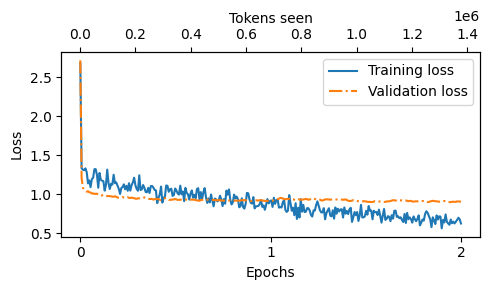

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### 10. Save LLM responses

In [41]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print()
    print(f"### Output:\n{response_text.strip()}")
    print(f"\nCorrect response:\n>> {entry['output']}")
    print()
    print()
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer the following question.

### Input:
How many countries and territories did Hilton's development pipeline encompass as of the end of 2023?

### Output:
As of the end of 2023, Hilton's development pipeline encompassed over 220 countries and territories.

Correct response:
>> 118


-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer the following question.

### Input:
How does the company manage fluctuations in foreign currency exchange rates?

### Output:
The company manages fluctuations in foreign currency exchange rates by hedging against them by purchasing U.S. dollar denominated debt securities and by purchasing U.S. dollar-denominated equity securities.

Correct response:
>> The company hedges foreign currency exchange-based cash flow vari

In [42]:
from tqdm import tqdm
import json

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 700/700 [11:38<00:00,  1.00it/s]


In [43]:
print(test_data[0])

{'instruction': 'Answer the following question.', 'input': "How many countries and territories did Hilton's development pipeline encompass as of the end of 2023?", 'output': '118', 'model_response': "As of the end of 2023, Hilton's development pipeline encompassed over 220 countries and territories."}


In [44]:
import re

# Save the model
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load the model (when needed)
# model.load_state_dict(torch.load("gpt2 -medium355M-sft.pth")

Model saved as gpt2-medium355M-sft.pth
